In [1]:
using Revise
using IonSim
using QuantumOptics: timeevolution, stochastic

In [2]:
import PyPlot
const plt = PyPlot;

In [3]:
# set some plot configs
plt.matplotlib.rc("xtick", top=false)
plt.matplotlib.rc("ytick", right=false, left=false)
plt.matplotlib.rc("axes", labelsize=20, titlesize=20, grid=true)
plt.matplotlib.rc("axes", linewidth=2)
plt.matplotlib.rc("grid", alpha=0.25, linestyle="--")
plt.matplotlib.rc("font", family="Palatino", weight="medium")
plt.matplotlib.rc("figure", figsize=(8,4))
plt.matplotlib.rc("xtick.major", width=2)
plt.matplotlib.rc("ytick.major", width=2)

In [4]:
C = Ca40(["S-1/2", "D-1/2"])
print(typeof(C) <: Ion)

true

In [5]:
?Ca40

search: 

Ca40



```
Ca40(selected_level_structure::Vector{String}[, stark_shift])
```

#### user-defined fields

  * `selected_level_structure`:    keys ⊂ `["S-1/2", "S+1/2", "D-5/2", "D-3/2", "D-1/2", "D+1/2", "D+3/2", "D+5/2"]`.   Values are a `NamedTuple` with:

      * `l`: orbital angular momentum
      * `j`: total angular momentum
      * `mⱼ`: projection of total angular momentum along quantization axis
      * `E`: relative energies

    Note: indexing the instantiated structure with one of these strings will return    the corresponding `Ket`.
  * `stark_shift`: A dictionary with keys denoting the selected levels and values, a real    number for describing a shift of the level's energy. This is just a convenient way to add    Stark shifts to the simulation without additional resources.

#### fixed fields

  * `mass::Real`: The ion's mass in kg.
  * `level_structure`: A full description of the ion's electronic structure.
  * `matrix_elements::OrderedDict{Tuple,Function}`: Same as `selected_matrix_elements` but for   all of the ion's allowed transitions.

#### derived fields

  * `selected_matrix_elements`: Functions for the allowed transitions (contained in the    selected levels) that return the corresponding coupling strengths. These functions take    as arguments:

      * `Efield`: magnitude of the electric field at the position of the ion [V/m]
      * `γ`: $ϵ̂⋅B̂$ (angle between laser polarization and B-field)
      * `ϕ`: $k̂⋅B̂$ (angle between laser k-vector and B-field)
  * `shape::Vector{Int}`: Indicates the dimension of the used Hilbert space.
  * `number`: When the ion is added to an `IonConfiguration`, this value keeps track of its    order in the chain.
  * `position`: @hen the ion is added to an `IonConfiguration`, this value keeps track of its   physical position in meters.


In [6]:
L = Laser()
print(L)

λ: 7.29147e-7

 m
Δ: 0 Hz
ϵ̂: (x=0.7071067811865475, y=0.7071067811865475, z=0.0)
k̂: (z=0, y=0, z=1)
E(t=0): 0 V/m
ϕ(t=0): 0 ⋅ 2π


In [7]:
chain = LinearChain(
        ions=[C], com_frequencies=(x=3e6,y=3e6,z=1e6), 
        vibrational_modes=(;z=[1])
    )
print(typeof(chain) <: IonConfiguration)

true

In [8]:
chain.vibrational_modes

(x = VibrationalMode[], y = VibrationalMode[], z = VibrationalMode[VibrationalMode(ν=1.0e6, axis=ẑ, N=10)])

In [9]:
T = Trap(configuration=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=[L]);

In [10]:
L.k = (x̂ + ẑ)/√2 
L.ϵ = (x̂ - ẑ)/√2;

┌ Warning: !(ϵ ⟂ k)
└ @ IonSim /Users/josephbroz/.julia/packages/IonSim/fbKtL/src/lasers.jl:84


In [11]:
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
L.Δ = Δf

2.239399193848153e6

In [12]:
?transition_frequency

search: transition_frequency



```
transition_frequency(
    B::Real, ion::Ion, transition::Union{Tuple{String,String},Vector{<:String}}
)
```

Compute the transition frequency of the `ion`'s selected transition under Bfield `B`. Alternatively, one may use:

```
transition_frequency(
        T::Trap, ion::Ion, transition::Union{Tuple{String,String},Vector{<:String}}
    )
```

which is the same as `transition_frequency(T.B, ion, transition)` or

```
transition_frequency(
        T::Trap, ion_index::Int, transition::Union{Tuple{String,String},Vector{<:String}}
    )
```

which is the same as `transition_frequency(T.B, T.configuration.ions[ion_index], transition)`.


In [13]:
Efield_from_pi_time!(2e-6, T, 1, 1, ("S-1/2", "D-1/2"));  # Sets pi_time to 2 μs

In [14]:
?Efield_from_pi_time

search: Efield_from_pi_time Efield_from_pi_time!



```
Efield_from_pi_time(
    pi_time::Real, Bhat::NamedTuple{(:x,:y,:z)}, laser::Laser, ion::Ion, 
    transition::Union{Tuple{String,String},Vector{<:String}}
)
```

Compute the E-field needed to get a certain `pi_time` with a certain `laser`-`ion`  `transition`.

Alternatively, one may use

```
Efield_from_pi_time(
            pi_time::Real, T::Trap, laser_index::Int, ion_index::Int, 
            transition::Union{Tuple{String,String},Vector{<:String}}
        )
```

which is the same as  `Efield_from_pi_time(pi_time, T.Bhat, T.lasers[laser_index], T.configuration.ions[ion_index], transition)`


In [15]:
?hamiltonian

search: hamiltonian



```
hamiltonian(
        T::Trap; timescale::Real=1e-6, lamb_dicke_order::Union{Vector{Int},Int}=1, 
        rwa_cutoff::Real=Inf, displacement="truncated", time_dependent_eta=false
    )
```

Constructs the Hamiltonian for `T` as a function of time. Return type is a function  `h(t::Real, ψ)` that, itself, returns a `QuantumOptics.SparseOperator`.

#### args

  * `timescale`: e.g. a value of 1e-6 will take time to be in $\mu s$
  * `lamb_dicke_order`: Only consider terms that change the phonon number by up to this value.   If this is an `Int`, then the cutoff is applied to all modes. If this is a `Vector{Int}`,   then `lamb_dicke_order[i]` is applied to the iᵗʰ mode, according to the order in    `T.basis`.   Note: this isn't quite the same thing as the Lamb-Dicke approximation since setting   `lamb_dicke_order=1` will retain, for example, terms proportional to $a^\dagger a$.
  * `rwa_cutoff`: drop terms in the Hamiltonian that oscillate faster than this cutoff. **Note:   if not using an RWA set to `Inf` (rather than a large number) for faster performance.**
  * `displacement`: This can be either `"truncated"`(default) or `"analytic"`. 

    When an atom is irradiated, both the atom's energy and its momentum will generally be   affected. For an atom in a harmonic potential, the exchange of momentum can be modeled as   a displacement operation $D(α=iηe^{-iνt}) = exp[αa^† - α^*a]$, where $η$ is the   Lamb-Dicke parameter, which can be described equivalently as either being proportional to   the square root of the ratio of the recoil frequency with the ground state energy of the   atom's motion or as the ratio of the spread of the ground state wavefunction to the   wavelength of the laser.

    When `"truncated"` is selected, the matrix elements of $D(α)$ are computed by   constructing $α^* a, αa^†$ in a truncated basis (according to the dimension specified in   your model) and then exponentiating their difference. This has the advantage, amongst   other things, of guaranting unitarity.

    If `"analytic"` is selected, then the matrix elements are computed assuming an infinite-  dimensional Hilbert space.

    For small displacements ($η ≪ N$, where $N$ is the dimension of the motion's Hilbert  space), both of these methods will be good approximations.
  * `time_dependent_eta::Bool`: In addition to impacting the vibrational subspace directly, a   change in the trap frequency, $δν$, will also change the Lamb-Dicke parameter. Since   typically $δν≪ν$, this effect will be small $η ≈ η₀(1 + δν/2ν)$ and doesn't warrant   the additional computational resources needed to calculate and update it in time. In this   case, we can set `time_dependent_eta=false` (default), which will set $η(t) = η₀$.


In [16]:
h = hamiltonian(T, timescale=1e-6);

In [17]:
tspan = 0:0.01:10
mode = T.configuration.vibrational_modes.z[1]
tout, sol = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ mode[0], h);

In [18]:
tspan = 0:0.01:10
mode = T.configuration.vibrational_modes.z[1]
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ mode[0], h);

  0.003203 seconds (97.46 k allocations: 3.436 MiB)


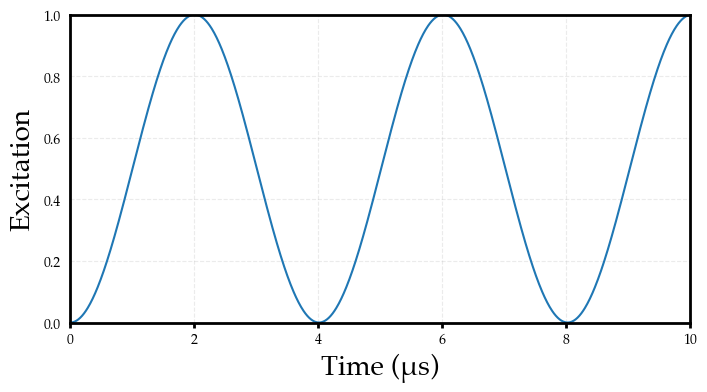

In [19]:
ex = expect(ionprojector(T, "D-1/2"), sol)
plt.plot(tout, ex)
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

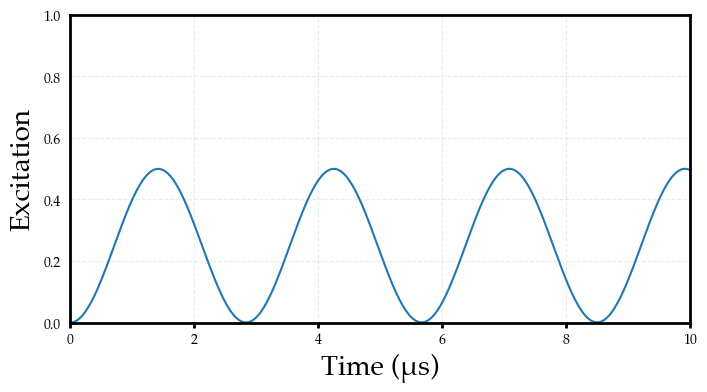

  0.033344 seconds (92.43 k allocations: 3.285 MiB, 89.31% gc time)


In [20]:
L.Δ = Δf + 2.5e5

h = hamiltonian(T, timescale=1e-6)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ mode[0], h)

ex = expect(ionprojector(T, "D-1/2"), sol)
plt.plot(tout, ex)
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

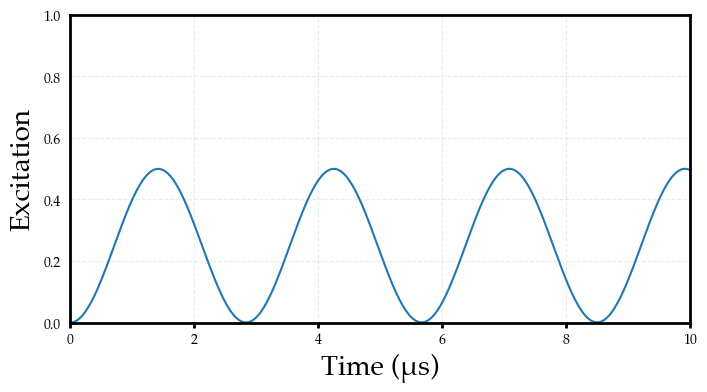

  0.003434 seconds (92.43 k allocations: 3.285 MiB)


In [21]:
L.Δ = Δf

C.stark_shift["S-1/2"] = -1.25e5
C.stark_shift["D-1/2"] = 1.25e5

h = hamiltonian(T, timescale=1e-6)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ mode[0], h)

ex = expect(ionprojector(T, "D-1/2"), sol)
plt.plot(tout, ex)
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

In [22]:
h = hamiltonian(T, timescale=1e-6, rwa_cutoff=Inf, time_dependent_eta=false, displacement="truncated")
tout, sol = timeevolution.schroedinger_dynamic(tspan, ψi, h);

UndefVarError: UndefVarError: ψi not defined

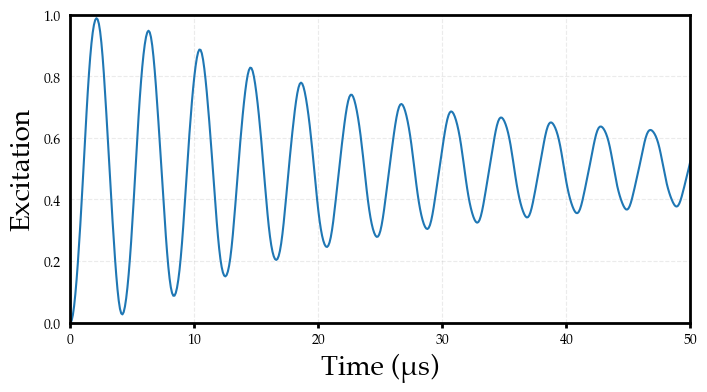

  6.880054 seconds (23.68 M allocations: 1.371 GiB, 6.75% gc time)


In [23]:
# reset all artificial Stark shifts to zero
zero_stark_shift(C)  

ψi_ion = dm(C["S-1/2"]) 

# we'd like to look at a pretty hot ion, so we need to increase our mode dimension, 
# which is set to N=10 by default here we set it to 100
mode.N = 100

ψi_mode = thermalstate(mode, 10)

ψi = ψi_ion ⊗ ψi_mode

tspan = 0:0.1:50
h = hamiltonian(T, timescale=1e-6, rwa_cutoff=Inf, time_dependent_eta=false, displacement="truncated")
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψi, h)

ex = expect(ionprojector(T, "D-1/2"), sol)
plt.plot(tout, ex)
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

In [24]:
?analytical.rabi_flop

```
rabi_flop(tspan, Ω::Real, η::Real, n̄::Real; s::Int=0) <br>
```

Single ion rabi flop. Returns: $\sum_{n=0}^∞ p_n sin^2(\Omega_n t)$ <br> with $\Omega_n = Ωe^{-η^2/2}η^s\sqrt{\frac{n!}{(n+s)!}}L_{n}^{s}(η^2)$ <br> where $s$ is the order of the (blue) sideband that we are driving and $L_{n}^{s}$ is the associated Laguerre polynomial. [ref](https://doi.org/10.1103/RevModPhys.75.281)


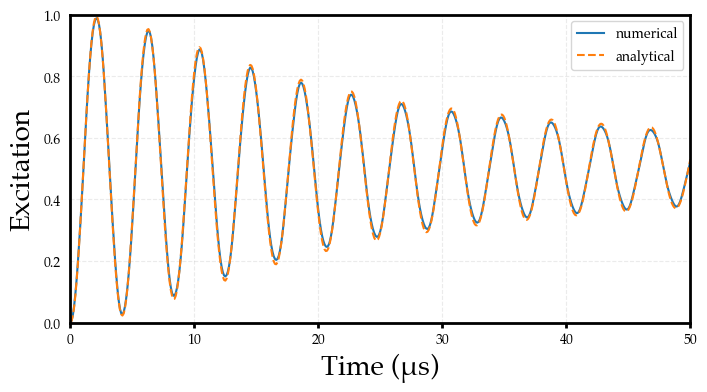

In [25]:
ex = expect(ionprojector(T, "D-1/2"), sol)
plt.plot(tout, ex, label="numerical")

η = get_η(mode, L, C)
plt.plot(
        tout, analytical.rabi_flop(tout, 1/4, η, 10), 
        linestyle="--", label="analytical"
    )
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

In [26]:
h = hamiltonian(T, lamb_dicke_order=0)  # set lamb_dicke_order here
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψi, h);

  0.768516 seconds (823.46 k allocations: 347.074 MiB, 24.30% gc time)


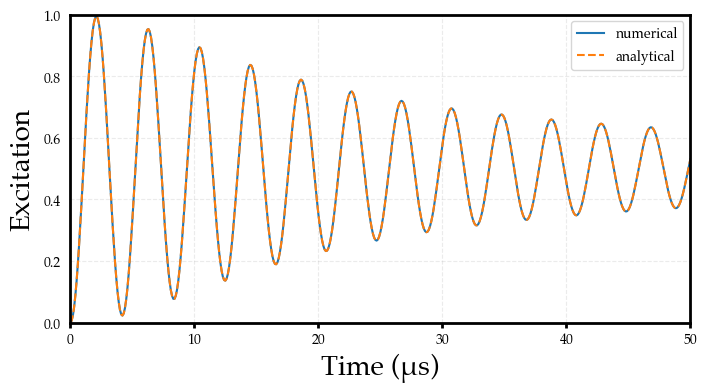

In [27]:
ex = expect(ionprojector(T, "D-1/2"), sol)
plt.plot(tout, ex, label="numerical")
η = get_η(mode, L, C)
plt.plot(
        tout, analytical.rabi_flop(tout, 1/4, η, 10), 
        linestyle="--", label="analytical"
    )
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

  0.041375 seconds (1.30 M allocations: 40.076 MiB)


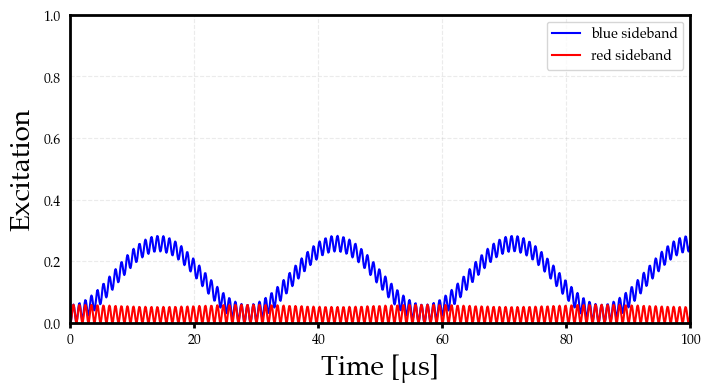

  0.046621 seconds (1.41 M allocations: 43.429 MiB)


In [28]:
tspan = 0:0.1:100
# set the motional dimension back to 10
mode.N = 10  

# tune laser frequency to blue sideband
L.Δ  = Δf + mode.ν  

h = hamiltonian(T)
@time tout, sol_blue = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ fockstate(mode, 0), h)

# tune laser frequency to red sideband
L.Δ  = Δf - mode.ν  

h = hamiltonian(T)
@time tout, sol_red = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ fockstate(mode, 0), h)

ex_blue = expect(ionprojector(T, "D-1/2"), sol_blue)
ex_red = expect(ionprojector(T, "D-1/2"), sol_red)
step = 1
plt.plot(tout[1:step:end], ex_blue[1:step:end], color="blue", label="blue sideband")
plt.plot(tout[1:step:end], ex_red[1:step:end], color="red", label="red sideband")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time [μs]");

  0.043004 seconds (1.50 M allocations: 46.198 MiB)


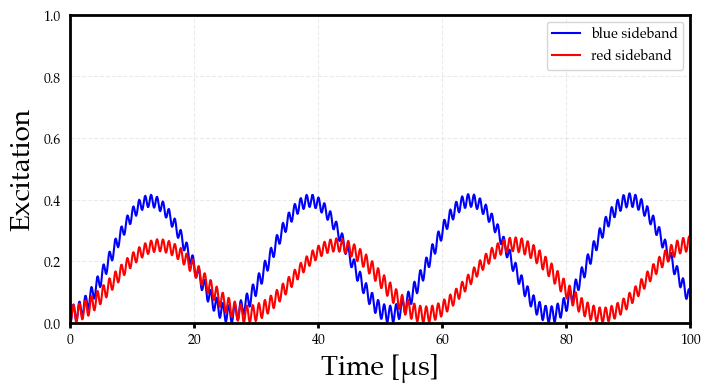

  0.040345 seconds (1.46 M allocations: 44.906 MiB)


In [29]:
L.Δ  = Δf + mode.ν  # tune laser frequency to blue sideband

h = hamiltonian(T)
@time tout, sol_blue = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ fockstate(mode, 1), h)

L.Δ  = Δf - mode.ν  # tune laser frequency to red sideband

h = hamiltonian(T, rwa_cutoff=1e7)
@time tout, sol_red = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ fockstate(mode, 1), h)

ex_blue = expect(ionprojector(T, "D-1/2"), sol_blue)
ex_red = expect(ionprojector(T, "D-1/2"), sol_red)
step = 1
plt.plot(tout[1:step:end], ex_blue[1:step:end], color="blue", label="blue sideband")
plt.plot(tout[1:step:end], ex_red[1:step:end], color="red", label="red sideband")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time [μs]");

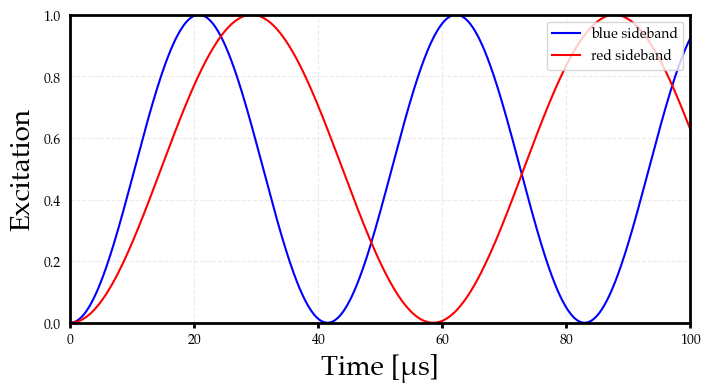

  0.000804 seconds (18.77 k allocations: 1.036 MiB)
  0.000630 seconds (14.93 k allocations: 940.812 KiB)


In [30]:
L.Δ  = Δf + mode.ν  # tune laser frequency to blue sideband

h = hamiltonian(T, rwa_cutoff=1e-5) # set rwa_cutoff here
@time tout, sol_blue = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ fockstate(mode, 1), h)

L.Δ  = Δf - mode.ν  # tune laser frequency to red sideband

h = hamiltonian(T, rwa_cutoff=1e-5) # set rwa_cutoff here
@time tout, sol_red = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ fockstate(mode, 1), h)

ex_blue = expect(ionprojector(T, "D-1/2"), sol_blue)
ex_red = expect(ionprojector(T, "D-1/2"), sol_red)
step = 1
plt.plot(tout[1:step:end], ex_blue[1:step:end], color="blue", label="blue sideband")
plt.plot(tout[1:step:end], ex_red[1:step:end], color="red", label="red sideband")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time [μs]");

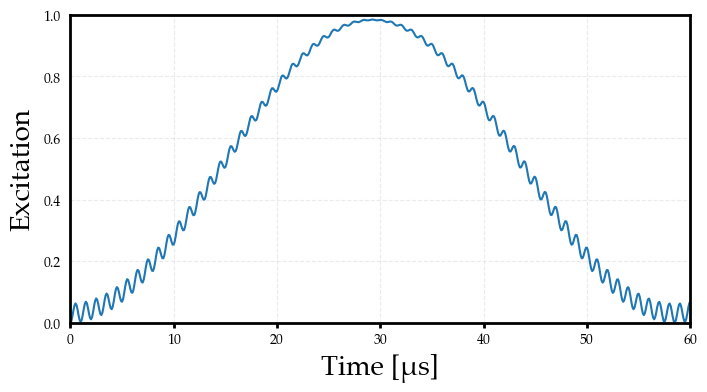

  0.025412 seconds (851.66 k allocations: 26.287 MiB)


In [31]:
L.Δ  = Δf + mode.ν - 31e3  # add additional detuning to BSB to compensate for carrier Stark shift

tspan = 0:0.1:60
h = hamiltonian(T)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ fockstate(mode, 0), h)


ex = expect(ionprojector(T, "D-1/2"), sol)
step = 1
plt.plot(tout[1:step:end], ex[1:step:end])
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time [μs]");

In [32]:
E = Efield_from_pi_time(2e-6, T, 1, 1, ("S-1/2", "D-1/2"))  # get previous value of electric field strength

# Simple amplitude ramping function
function Ω(t)
    if t < 4
        return E * sin(2π * t / 16)^2
    end
    E
end;

L.E = Ω;

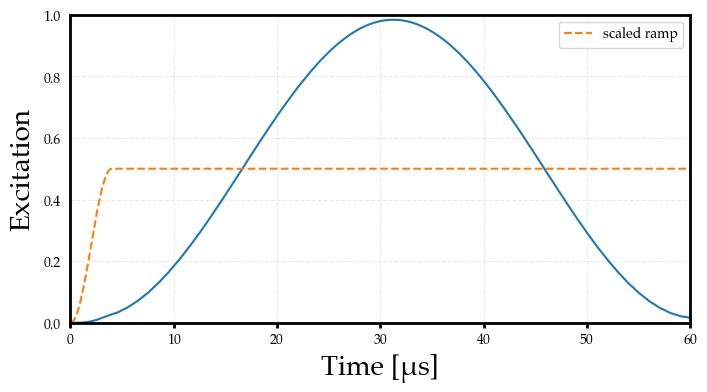

  0.050166 seconds (1.28 M allocations: 36.054 MiB)


In [33]:
L.Δ  = Δf + mode.ν - 31e3  # add additional detuning to BSB to compensate for carrier Stark shift

tspan = 0:0.1:60
h = hamiltonian(T)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ fockstate(mode, 0), h)


ex = expect(ionprojector(T, "D-1/2"), sol)
step = 1
plt.plot(tout[1:step:end], ex[1:step:end])
plt.plot(tout, @.(Ω(tout) / 2E), linestyle="--", label="scaled ramp")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time [μs]");

In [34]:
# To make things interesting let's also reduce the ramp time from 4 μs to 1 μs
L.E = t -> t < 1 ?  E * sin(2π * t / 4)^2 : E;

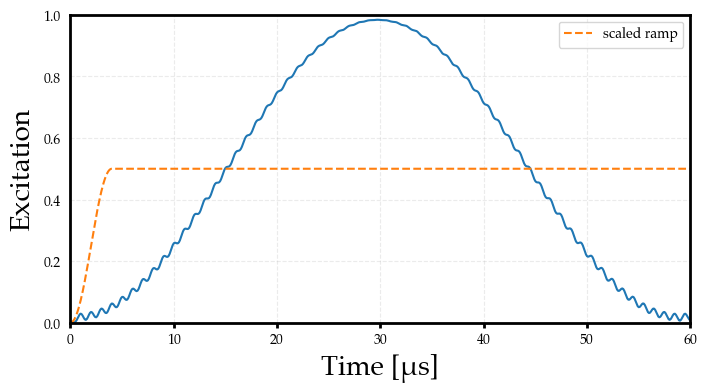

  0.051266 seconds (1.29 M allocations: 36.205 MiB)


In [35]:
L.Δ  = Δf + mode.ν - 31e3  # add additional detuning to BSB to compensate for carrier Stark shift

tspan = 0:0.1:60
h = hamiltonian(T)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ fockstate(mode, 0), h)


ex = expect(ionprojector(T, "D-1/2"), sol)
step = 1
plt.plot(tout[1:step:end], ex[1:step:end])
plt.plot(tout, @.(Ω(tout) / 2E), linestyle="--", label="scaled ramp")
plt.xlim(tout[1], tout[end])
plt.legend(loc=1)
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time [μs]");

In [36]:
# We'll linearly sweep through the laser's frequency from -150 kHz to +150 kHz detuned from the carrier transition
# in a time Tp

Tp = 150 # the length of time of the frequency chirp in μs
Δϕ = 2π * 150e-3  # this is equal to half the detuning range we will chirp the laser over multiplied by the timescale (1e-6)
L.ϕ = t -> (-Δϕ + (2Δϕ / Tp) * t) * t

# We'll also ramp the Rabi frequency. Note I wasn't able to match the results from the paper when using a Gaussian profile, as they
# as described in the referenced paper
E = Efield_from_pi_time(6.5e-6, T, 1, 1, ("S-1/2", "D-1/2"))
tr = 33
function Ω(t)
    if t < tr
        return E * sin(2π * t / 4tr)^2
    elseif tr <= t <= 150 - tr
        return E
    elseif 150 - tr < t < 150
        return E * sin(2π * (t - 150) / 4tr)^2
    else
        return 0
    end
end
L.E = Ω;

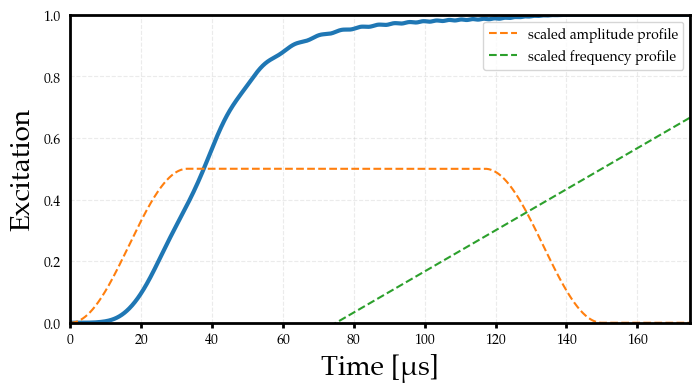

  0.165072 seconds (3.43 M allocations: 75.439 MiB, 27.16% gc time)


In [37]:
T.B = 2.9e-4  # Set the B-field to match the value in the reference
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))

L.Δ  = Δf  # set detuning back to carrier 

tspan = 0:0.1:175
h = hamiltonian(T)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ fockstate(mode, 0), h)


ex = expect(ionprojector(T, "D-1/2"), sol)
step = 1
plt.plot(tout[1:step:end], ex[1:step:end], lw=3)
plt.plot(tout, @.(L.E(tout) / 2E), linestyle="--", label="scaled amplitude profile")
plt.plot(tout, @.(L.ϕ(tout) / (2Δϕ * tout)), linestyle="--", label="scaled frequency profile")
plt.xlim(tout[1], tout[end])
plt.legend(loc=1)
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time [μs]");

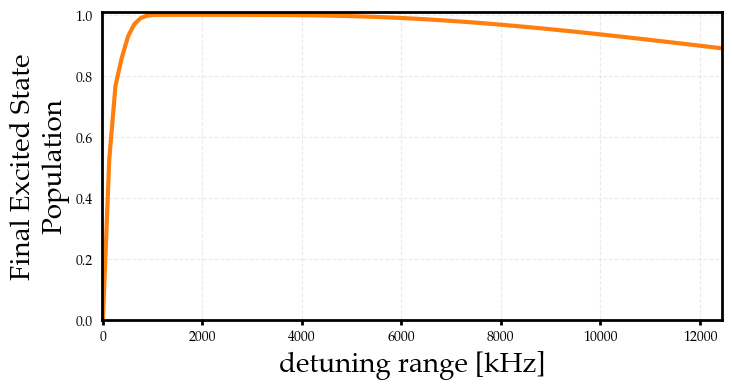

In [38]:
detuning_range = 2π*1e-6 .* collect(1e3:2e4:2e6)
pops = Vector{Float64}(undef, 0)
for Δϕ in detuning_range
    L.ϕ = t -> (-Δϕ/2 + (Δϕ / Tp) * t) * t
    h = hamiltonian(T)
    _, sol = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ fockstate(mode, 0), h)
    push!(pops, real(expect(ionprojector(T, "D-1/2"), sol)[end]))
end
plt.plot(@.(detuning_range * 1e3), pops, lw=3, color="C1")
plt.xlim(-10, detuning_range[end] * 1e3)
plt.ylim(0, 1.01)
plt.ylabel("Final Excited State\nPopulation")
plt.xlabel("detuning range [kHz]");

In [39]:
L.ϕ = 0  # get rid of frequency chirp
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))  # and recompute the transition frequency
L.Δ = Δf;

In [40]:
using StochasticDiffEq

In [41]:
tspan = collect(0:10.:30000)
β = 1e-2
σ = √(2β)
w = StochasticDiffEq.OrnsteinUhlenbeckProcess(β, 0.0, σ, 0.0, 0.0)
w.dt = 0.1;

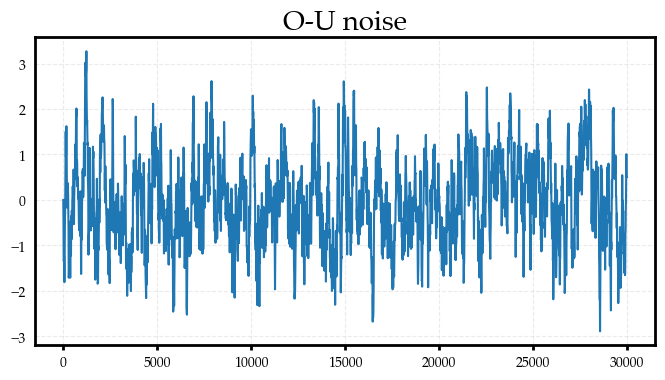

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9ef0910550>

In [42]:
plt.title("O-U noise")
warray = [w(t)[1] for t in tspan]
plt.plot(tspan, warray)

In [43]:
using DSP: periodogram

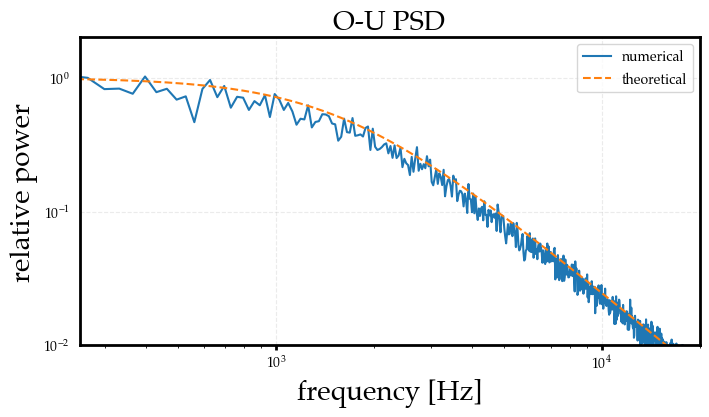

PyObject <matplotlib.legend.Legend object at 0x7f9e9900e310>

In [44]:
sample_rate = (length(tspan) - 1)/tspan[end]
pwarray = periodogram(warray, fs=sample_rate)
freqs = pwarray.freq
abs_freqs = freqs .* 1e6
powers = pwarray.power
N = 50
for i in 1:N-1
    w = StochasticDiffEq.OrnsteinUhlenbeckProcess(β, 0.0, σ, 0.0, 0.0)
    w.dt = 0.1
    warray = [w(t)[1] for t in tspan]
    powers .+= periodogram(warray, fs=sample_rate).power
end
powers ./= powers[2]

plt.loglog(abs_freqs, powers, label="numerical")
ou_psd(f) = σ^2 / (β^2 + (2π * f)^2)
plt.loglog(abs_freqs, ou_psd.(freqs) ./ ou_psd(freqs[2]), color="C1", label="theoretical", ls="--")
plt.ylabel("relative power")
plt.xlabel("frequency [Hz]")
plt.title("O-U PSD")
plt.ylim(10e-3, 2)
plt.xlim(250, 2e4)
plt.legend()

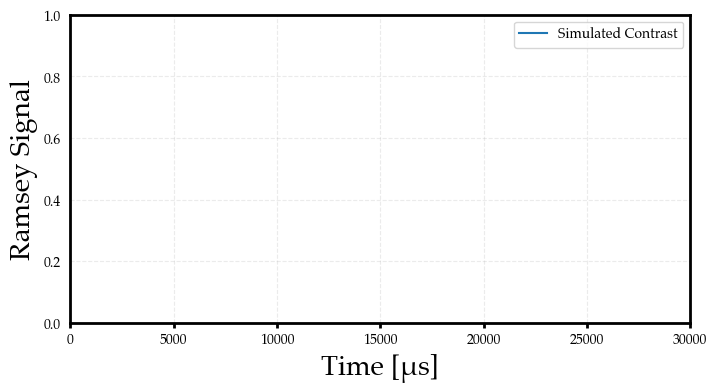

In [45]:
mode.N = 1  # we're not paying attention to the vibrational mode here, so we set its dimension to 1

# construct a zero operator
L.E = 0
T.δB = 5e-8
h = hamiltonian(T)

# let's work with a Δm=2 transition
T.configuration.ions[1].selected_level_structure = ["S-1/2", "D-5/2"]

# construct noise operator
T.δB = 5e-7
hs = hamiltonian(T)
hsvec = (t,ψ) -> [hs(t, ψ)]

ψi_ion = (ionstate(T, "S-1/2") + ionstate(T, "D-5/2"))/√2
ψi_mode = fockstate(mode, 0)
ψi = ψi_ion ⊗ ψi_mode

Ntraj = 100
ex = zero(tspan)

# iterate SDE solver Ntraj times and avergage results
w = StochasticDiffEq.OrnsteinUhlenbeckProcess(β, 0.0, σ, 0.0, 0.0)
for i in 1:Ntraj
    tout, sol = stochastic.schroedinger_dynamic(tspan, ψi, h, hsvec, noise=w,
    normalize_state=true, dt=0.1)
    ex .+= real.(expect(dm(ψi_ion) ⊗ one(mode), sol)) ./ Ntraj
end

step = 1
plt.plot(tspan[1:step:end], ex[1:step:end], color="C0", label="Simulated Contrast")
plt.xlim(tspan[1], tspan[end])
plt.ylim(0, 1)
plt.legend()
plt.ylabel("Ramsey Signal")
plt.xlabel("Time [μs]");

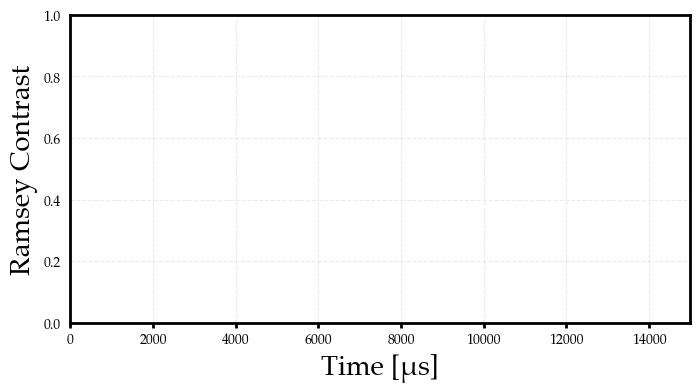

  3.867368 seconds (12.06 M allocations: 584.632 MiB, 4.19% gc time)


In [46]:
γ1 = hs(1.0, 0).data[1, 1]/40
γ2 = hs(1.0, 0).data[2, 2]/40

rates = 1/4π .* abs.([γ1, γ2])

hs1 = C["S-1/2"] ⊗ C["S-1/2"]' ⊗ one(mode)
hs2 = C["D-5/2"] ⊗ C["D-5/2"]' ⊗ one(mode)

tspan = collect(0:1.:15000)
@time tout, sol = timeevolution.master(tspan, dm(ψi), h(1.0, 0.0), [hs1, hs2], rates=rates)

ex = expect(dm(ψi_ion) ⊗ one(mode), sol)
step = 1
plt.plot(tspan[1:step:end], ex[1:step:end])
plt.xlim(tspan[1], tspan[end])
plt.ylim(0, 1)
plt.ylabel("Ramsey Contrast")
plt.xlabel("Time [μs]");

In [47]:
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))  #recompute the transition frequency
L.Δ = Δf

T.configuration.ions[1].selected_level_structure = ["S-1/2", "D-1/2"]
T.B = 4e-4
T.δB = 0
E = Efield_from_pi_time(2e-6, T, 1, 1, ("S-1/2", "D-1/2"))
L.Δ = Δf
tspan = 0:0.1:60

# average over Ntraj runs
Ntraj = 500
δE = 0.025E
ex = zero(tspan)
ψi = ionstate(T, "S-1/2") ⊗ fockstate(mode, 0)
@time begin
    for i in 1:Ntraj
        ΔE = δE * randn()
        L.E = E + ΔE 
        h = hamiltonian(T)
        tout, sol = timeevolution.schroedinger_dynamic(tspan, ψi, h)
        ex .+= expect(ionprojector(T, "D-1/2"), sol) ./ Ntraj
    end
end

# compute expected τ
hz_per_E = 1 / Efield_from_rabi_frequency(1, ẑ, L, C, ("S-1/2", "D-1/2"))
τ_us = 1e6 / (2π * δE * hz_per_E)

step = 1
plt.plot(tspan[1:step:end], ex[1:step:end])
plt.plot(tspan, @.((1 + exp(-(tspan / (√2 * τ_us))^2))/2), color="C1", ls="--", label="Gaussian Envelope")
plt.plot(tspan, @.((1 - exp(-(tspan / (√2 * τ_us))^2))/2), color="C1", ls="--")
plt.xlim(tspan[1], tspan[end])
plt.ylim(0, 1)
plt.legend()
plt.ylabel("Excitation")
plt.xlabel("Time [μs]");

KeyError: KeyError: key "D-1/2" not found

In [48]:
# Construct the system
C = Ca40(["S-1/2", "D-1/2"])
L1 = Laser(); L2 = Laser() 
chain = LinearChain(ions=[C, C], com_frequencies=(x=3e6,y=3e6,z=1e6), vibrational_modes=(;z=[1]))
T = Trap(configuration=chain, B=4e-4, Bhat=(x̂ + ẑ)/√2, lasers=[L1, L2]);

┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /Users/josephbroz/.julia/packages/IonSim/fbKtL/src/ion_configurations.jl:160


In [49]:
# Set the laser parameters
ϵ = 40e3
d = 80  # corrects for AC stark shift from single-photon coupling to sidebands
mode = T.configuration.vibrational_modes.z[1]
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
L1.Δ = Δf + mode.ν + ϵ - d
L1.k = ẑ
L1.ϵ = x̂

L2.Δ = Δf - mode.ν - ϵ + d
L2.k = ẑ
L2.ϵ = x̂

mode.N = 5
η = abs(get_η(mode, L1, C))
Ω1 = √(1e3 * ϵ) / η  # This will give a 1kHz MS strength, since coupling goes like (ηΩ)^2/ϵ

Efield_from_rabi_frequency!(Ω1, T, 1, 1, ("S-1/2", "D-1/2"))
Efield_from_rabi_frequency!(Ω1, T, 2, 1, ("S-1/2", "D-1/2"));

In [50]:
ψi = ionstate(T, "S-1/2", "S-1/2") ⊗ fockstate(mode, 0);  # initial state

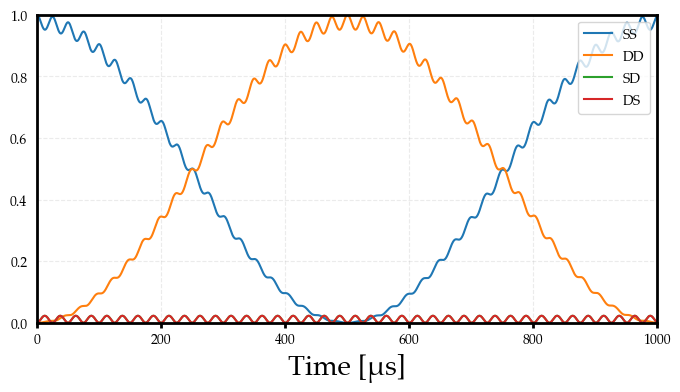

  3.202617 seconds (11.02 M allocations: 538.575 MiB, 5.66% gc time)


In [51]:
# setup and run the Hamiltonian
h = hamiltonian(T, rwa_cutoff=5e5)
tspan = 0:0.25:1000
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψi, h);

SS = expect(ionprojector(T, "S-1/2", "S-1/2"), sol)
DD = expect(ionprojector(T, "D-1/2", "D-1/2"), sol)
SD = expect(ionprojector(T, "S-1/2", "D-1/2"), sol)
DS = expect(ionprojector(T, "D-1/2", "S-1/2"), sol)
plt.plot(tout[1:end], SS[1:end], label="SS")
plt.plot(tout[1:end], DD[1:end], label="DD")
plt.plot(tout[1:end], SD[1:end], label="SD")
plt.plot(tout[1:end], DS[1:end], label="DS")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time [μs]");

In [52]:
?analytical.two_ion_ms

```
two_ion_ms(tspan, Ω::Real, ν::Real, δ::Real, η::Real, n̄::Real)
```

[ref](https://doi.org/10.1103/PhysRevA.62.022311) <br> Assumes vibrational mode starts in a thermal state with: $\langle a^\dagger a\rangle = n̄$  and ions start in doubly ground state. Returns `(ρgg, ρee)`, the population in the doubly  ground and doubly excited state, respectively. $[Ω], [ν], [δ] = Hz$


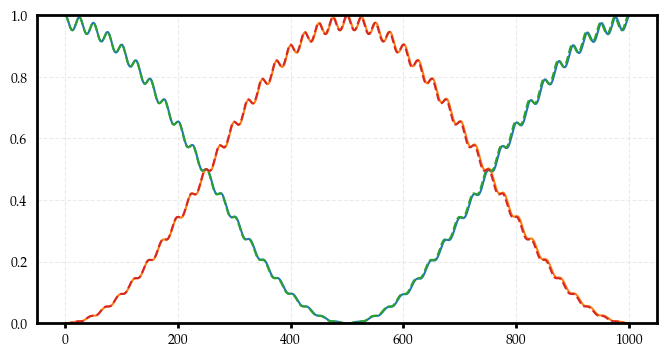

In [53]:
ex = analytical.two_ion_ms(tspan, 1e-6Ω1, 1e-6mode.ν, 1e-6mode.ν + 1e-6ϵ, η, 0)
plt.plot(tspan, SS)
plt.plot(tspan, DD)
plt.plot(tspan, ex[1], ls="--")
plt.plot(tspan, ex[2], ls="--")
plt.ylim(0, 1);

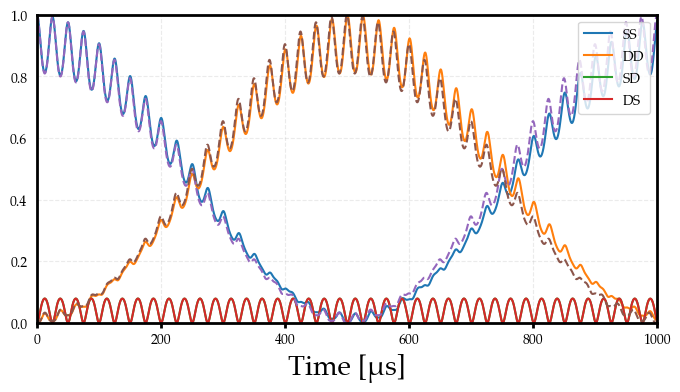

  4.141416 seconds (14.21 M allocations: 896.552 MiB, 6.13% gc time)


In [54]:
mode.N = 15
ρi = dm(ionstate(T, "S-1/2", "S-1/2")) ⊗ thermalstate(mode, 2)  # thermal state
h = hamiltonian(T, rwa_cutoff=5e5)
tspan = collect(0:0.25:1000)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ρi, h)

SS = expect(ionprojector(T, "S-1/2", "S-1/2"), sol)
DD = expect(ionprojector(T, "D-1/2", "D-1/2"), sol)
SD = expect(ionprojector(T, "S-1/2", "D-1/2"), sol)
DS = expect(ionprojector(T, "D-1/2", "S-1/2"), sol)
plt.plot(tout[1:end], SS[1:end], label="SS")
plt.plot(tout[1:end], DD[1:end], label="DD")
plt.plot(tout[1:end], SD[1:end], label="SD")
plt.plot(tout[1:end], DS[1:end], label="DS")
ex = analytical.two_ion_ms(tspan, 1e-6Ω1, 1e-6mode.ν, 1e-6mode.ν + 1e-6ϵ, η, 2)
plt.plot(tspan, ex[1], ls="--")
plt.plot(tspan, ex[2], ls="--")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time [μs]");

┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /Users/josephbroz/.julia/packages/IonSim/fbKtL/src/ion_configurations.jl:160


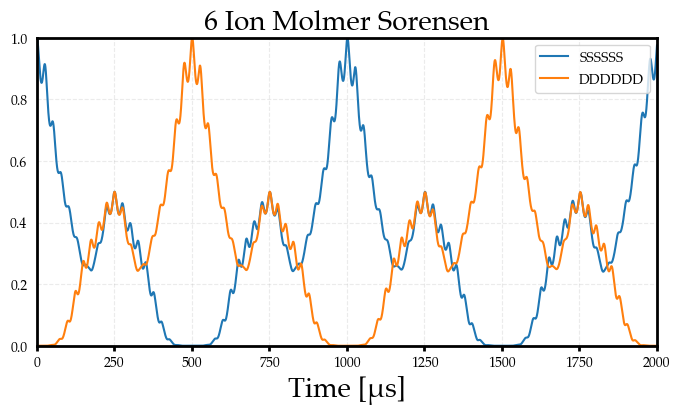

  4.424917 seconds (17.86 M allocations: 798.075 MiB, 7.24% gc time)


In [55]:
chain = LinearChain(ions=[C, C, C, C, C, C], com_frequencies=(x=3e6,y=3e6,z=1e6), vibrational_modes=(;z=[1]))
T = Trap(configuration=chain, B=4e-4, Bhat=(x̂ + ẑ)/√2, lasers=[L1, L2])
global_beam!(T, L1)  # set L1 to shine equally on all ions
global_beam!(T, L2)  # set L2 to shine equally on all ions
mode = T.configuration.vibrational_modes.z[1]
mode.N = 5
η = abs(get_η(mode, L1, C))
Ω2 = √(1e3 * ϵ) / η  
Efield_from_rabi_frequency!(Ω2, T, 1, 1, ("S-1/2", "D-1/2"))
Efield_from_rabi_frequency!(Ω2, T, 2, 1, ("S-1/2", "D-1/2"))
ψi = ionstate(T, repeat(["S-1/2"], 6)...) ⊗ fockstate(mode, 0)

h = hamiltonian(T, rwa_cutoff=5e5)
tspan = 0:0.25:2000
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψi, h);

S = expect(ionprojector(T, repeat(["S-1/2"], 6)...), sol)
D = expect(ionprojector(T, repeat(["D-1/2"], 6)...), sol)
plt.plot(tout[1:end], S[1:end], label="SSSSSS")
plt.plot(tout[1:end], D[1:end], label="DDDDDD")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.title("6 Ion Molmer Sorensen")
plt.xlabel("Time [μs]");

In [56]:
const pc = IonSim.PhysicalConstants;

In [57]:
pc.ħ

1.0545718e-34 [m²kg/s]

In [58]:
pc.c

2.99792458e8 [m/s]

In [59]:
print(pc.μB / pc.ħ, "\n")
print(pc.ħ + pc.c, "\n")
print(pc.α^pc.α, "\n")

8.794100069810324e10
2.99792458e8
0.9647321772836126
